/usr/local/lib/python3.8/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


torch.Size([1, 8, 256, 256])
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[Episode Start] Currently using dataset file: ('dataset6/0011.png',), Episode count: 1
Polynomial Reward Function Equation:
           5             4             3             2
3.556e-20 x - 7.351e-16 x + 1.347e-12 x + 6.577e-08 x - 0.000563 x + 1.001

Time taken for psnr_change_list: 17.30 seconds
[Dynamic Threshold] T_PSNR_DIFF set to: 0.094549
Initial PSNR: 25.665585
Initial MSE: 0.002207

üî• Most Probable Action:
Index: 103849 | Channel: 1, Row: 149, Col: 169 | Probability: 0.003114

üéØ Action Probability Histogram:
[0.00, 0.05): 524288 actions
[0.05, 0.10): 0 actions
[0.10, 0.15): 0 actions
[0.15, 0.20): 0 actions
[0.20, 0.25): 0 actions
[0.25, 0.30): 0 actions
[0.30, 0.35): 0 actions
[0.35, 0.40): 0 actions
[0.40, 0.45): 0 actions
[0.45, 0.50): 0 actions
[0.50, 0.55): 0 actions
[0.55, 0.60): 0 actions
[0.60, 0.65): 0 actions
[0.65, 0.70): 0 actions
[0.70, 0.75): 0 actio

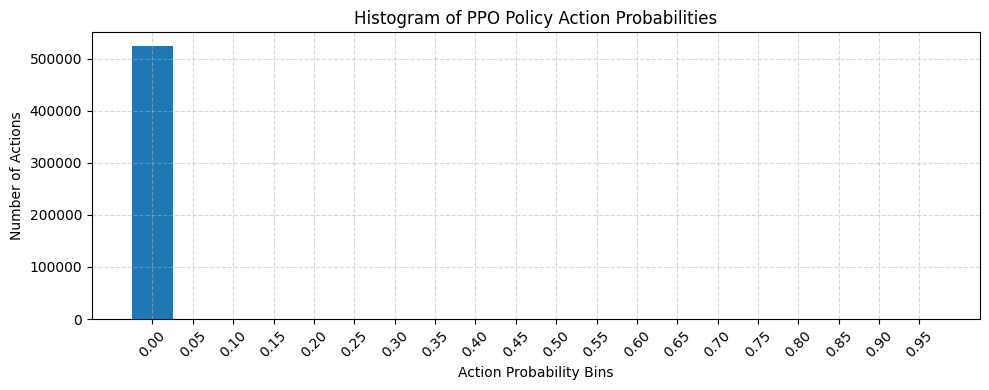


üéØ Action Probability Histogram (0 ~ 0.003114):
[0.000000, 0.000031): 517646 actions
[0.000031, 0.000062): 3402 actions
[0.000062, 0.000093): 1252 actions
[0.000093, 0.000125): 584 actions
[0.000125, 0.000156): 334 actions
[0.000156, 0.000187): 195 actions
[0.000187, 0.000218): 126 actions
[0.000218, 0.000249): 104 actions
[0.000249, 0.000280): 83 actions
[0.000280, 0.000311): 76 actions
[0.000311, 0.000342): 50 actions
[0.000342, 0.000374): 40 actions
[0.000374, 0.000405): 33 actions
[0.000405, 0.000436): 45 actions
[0.000436, 0.000467): 30 actions
[0.000467, 0.000498): 22 actions
[0.000498, 0.000529): 24 actions
[0.000529, 0.000560): 19 actions
[0.000560, 0.000592): 15 actions
[0.000592, 0.000623): 11 actions
[0.000623, 0.000654): 17 actions
[0.000654, 0.000685): 10 actions
[0.000685, 0.000716): 16 actions
[0.000716, 0.000747): 14 actions
[0.000747, 0.000778): 9 actions
[0.000778, 0.000810): 8 actions
[0.000810, 0.000841): 5 actions
[0.000841, 0.000872): 9 actions
[0.000872, 0.000

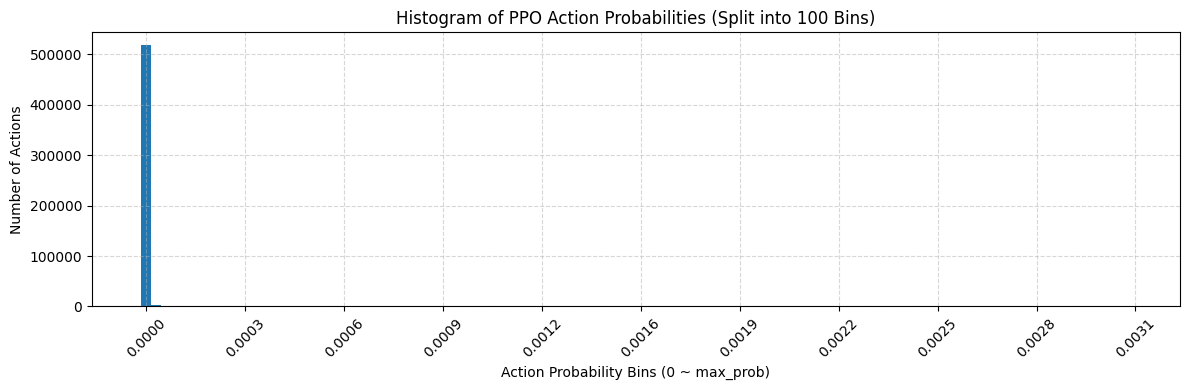

üîπ PSNR before flipping: 25.6656
Flipped: Channel=1, Row=149, Col=169, Prob=0.003114
Flipped: Channel=4, Row=153, Col=147, Prob=0.002804
üî∏ PSNR after flipping:  25.6649
üîÅ PSNR change:          -0.0007
[Episode Start] Currently using dataset file: ('dataset6/0002.png',), Episode count: 2
Polynomial Reward Function Equation:
           5             4             3             2
3.556e-20 x - 7.351e-16 x + 1.347e-12 x + 6.577e-08 x - 0.000563 x + 1.001

Time taken for psnr_change_list: 21.02 seconds
[Dynamic Threshold] T_PSNR_DIFF set to: 0.099570
Initial PSNR: 25.856892
Initial MSE: 0.002596


AttributeError: 'float' object has no attribute 'item'

In [1]:
import os
import glob
import shutil
from datetime import datetime
import time
import warnings

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader

import torchvision

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback, CallbackList

import torchOptics.optics as tt
import torchOptics.metrics as tm

import matplotlib.pyplot as plt

from env import BinaryHologramEnv

IPS = 256  #Ïù¥ÎØ∏ÏßÄ ÌîΩÏÖÄ ÏÇ¨Ïù¥Ï¶à
CH = 8  #Ï±ÑÎÑê
RW = 800  #Î≥¥ÏÉÅ

warnings.filterwarnings('ignore')

# ÌòÑÏû¨ ÎÇ†ÏßúÏôÄ ÏãúÍ∞ÑÏùÑ Í∞ÄÏ†∏ÏôÄ Ìè¨Îß∑ ÏßÄÏ†ï
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.backends.cudnn.enabled = False

class BinaryNet(nn.Module):
    def __init__(self, num_hologram, final='Sigmoid', in_planes=3,
                 channels=[32, 64, 128, 256, 512, 1024, 2048, 4096],
                 convReLU=True, convBN=True, poolReLU=True, poolBN=True,
                 deconvReLU=True, deconvBN=True):
        super(BinaryNet, self).__init__()

        def CRB2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, relu=True, bn=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            if relu:
                layers += [nn.Tanh()]
            if bn:
                layers += [nn.BatchNorm2d(num_features=out_channels)]

            cbr = nn.Sequential(*layers)  # *ÏúºÎ°ú list unpacking

            return cbr

        def TRB2d(in_channels, out_channels, kernel_size=2, stride=2, bias=True, relu=True, bn=True):
            layers = []
            layers += [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                          kernel_size=2, stride=2, padding=0,
                                          bias=True)]
            if bn:
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            if relu:
                layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)  # *ÏúºÎ°ú list unpacking

            return cbr

        self.enc1_1 = CRB2d(in_planes, channels[0], relu=convReLU, bn=convBN)
        self.enc1_2 = CRB2d(channels[0], channels[0], relu=convReLU, bn=convBN)
        self.pool1 = CRB2d(channels[0], channels[0], stride=2, relu=poolReLU, bn=poolBN)

        self.enc2_1 = CRB2d(channels[0], channels[1], relu=convReLU, bn=convBN)
        self.enc2_2 = CRB2d(channels[1], channels[1], relu=convReLU, bn=convBN)
        self.pool2 = CRB2d(channels[1], channels[1], stride=2, relu=poolReLU, bn=poolBN)

        self.enc3_1 = CRB2d(channels[1], channels[2], relu=convReLU, bn=convBN)
        self.enc3_2 = CRB2d(channels[2], channels[2], relu=convReLU, bn=convBN)
        self.pool3 = CRB2d(channels[2], channels[2], stride=2, relu=poolReLU, bn=poolBN)

        self.enc4_1 = CRB2d(channels[2], channels[3], relu=convReLU, bn=convBN)
        self.enc4_2 = CRB2d(channels[3], channels[3], relu=convReLU, bn=convBN)
        self.pool4 = CRB2d(channels[3], channels[3], stride=2, relu=poolReLU, bn=poolBN)

        self.enc5_1 = CRB2d(channels[3], channels[4], relu=convReLU, bn=convBN)
        self.enc5_2 = CRB2d(channels[4], channels[4], relu=convReLU, bn=convBN)

        self.deconv4 = TRB2d(channels[4], channels[3], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec4_1 = CRB2d(channels[4], channels[3], relu=convReLU, bn=convBN)
        self.dec4_2 = CRB2d(channels[3], channels[3], relu=convReLU, bn=convBN)

        self.deconv3 = TRB2d(channels[3], channels[2], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec3_1 = CRB2d(channels[3], channels[2], relu=convReLU, bn=convBN)
        self.dec3_2 = CRB2d(channels[2], channels[2], relu=convReLU, bn=convBN)

        self.deconv2 = TRB2d(channels[2], channels[1], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec2_1 = CRB2d(channels[2], channels[1], relu=convReLU, bn=convBN)
        self.dec2_2 = CRB2d(channels[1], channels[1], relu=convReLU, bn=convBN)

        self.deconv1 = TRB2d(channels[1], channels[0], relu=deconvReLU, bn=deconvBN, stride=2)
        self.dec1_1 = CRB2d(channels[1], channels[0], relu=convReLU, bn=convBN)
        self.dec1_2 = CRB2d(channels[0], channels[0], relu=convReLU, bn=convBN)

        self.classifier = CRB2d(channels[0], num_hologram, relu=False, bn=False)

    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        deconv4 = self.deconv4(enc5_2)
        concat4 = torch.cat((deconv4, enc4_2), dim=1)
        dec4_1 = self.dec4_1(concat4)
        dec4_2 = self.dec4_2(dec4_1)

        deconv3 = self.deconv3(dec4_2)
        concat3 = torch.cat((deconv3, enc3_2), dim=1)
        dec3_1 = self.dec3_1(concat3)
        dec3_2 = self.dec3_2(dec3_1)

        deconv2 = self.deconv2(dec3_2)
        concat2 = torch.cat((deconv2, enc2_2), dim=1)
        dec2_1 = self.dec2_1(concat2)
        dec2_2 = self.dec2_2(dec2_1)

        deconv1 = self.deconv1(dec2_2)
        concat1 = torch.cat((deconv1, enc1_2), dim=1)
        dec1_1 = self.dec1_1(concat1)
        dec1_2 = self.dec1_2(dec1_1)

        # Final classifier
        out = self.classifier(dec1_2)
        out = nn.Sigmoid()(out)
        return out


model = BinaryNet(num_hologram=CH, in_planes=1, convReLU=False,
                  convBN=False, poolReLU=False, poolBN=False,
                  deconvReLU=False, deconvBN=False).cuda()
test = torch.randn(1, 1, IPS, IPS).cuda()
out = model(test)
print(out.shape)

class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True, padding=0):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(IPS)
        self.random_crop = torchvision.transforms.RandomCrop((IPS, IPS))
        self.padding = padding

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=self.meta, gray=True).unsqueeze(0)
        if target.shape[-1] < IPS or target.shape[-2] < IPS:
            target = torchvision.transforms.Resize(IPS)(target)
        if self.isTrain:
            target = self.random_crop(target)
            target = torchvision.transforms.functional.pad(target, (self.padding, self.padding, self.padding, self.padding))
        else:
            target = self.center_crop(target)
            target = torchvision.transforms.functional.pad(target, (self.padding, self.padding, self.padding, self.padding))
        # Îç∞Ïù¥ÌÑ∞ÏôÄ ÌååÏùº Í≤ΩÎ°úÎ•º Ìï®Íªò Î∞òÌôò
        return target, self.target_list[idx]

# ÏóêÌîºÏÜåÎìú Î≥¥ÏÉÅ Î°úÍπÖ ÏΩúÎ∞±
class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=1):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []  # Í∞Å ÏóêÌîºÏÜåÎìú Î≥¥ÏÉÅÏùÑ Ï†ÄÏû•
        self.current_episode_reward = 0  # ÌòÑÏû¨ ÏóêÌîºÏÜåÎìúÏùò Î≥¥ÏÉÅ
        self.episode_count = 0  # ÏóêÌîºÏÜåÎìú ÏàòÎ•º Ï∂îÏ†Å

    def _on_step(self) -> bool:
        # ÌòÑÏû¨ Ïä§ÌÖùÏùò Î≥¥ÏÉÅÏùÑ ÎàÑÏ†Å
        reward = self.locals["rewards"]
        self.current_episode_reward += reward[0]  # Ï≤´ Î≤àÏß∏ ÌôòÍ≤ΩÏùò Î≥¥ÏÉÅ

        # ÏóêÌîºÏÜåÎìú Ï¢ÖÎ£å Ï≤òÎ¶¨
        if self.locals["dones"][0]:  # Ï≤´ Î≤àÏß∏ ÌôòÍ≤ΩÏóêÏÑú ÏóêÌîºÏÜåÎìú Ï¢ÖÎ£å Ïãú
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_count += 1

            if self.verbose > 0:
                print(f"\033[41mEpisode {self.episode_count}: Total Reward: {self.current_episode_reward:.2f}\033[0m")

            # ÌòÑÏû¨ ÏóêÌîºÏÜåÎìú Î≥¥ÏÉÅÏùÑ Ï¥àÍ∏∞Ìôî
            self.current_episode_reward = 0

        return True  # ÌïôÏäµ Í≥ÑÏÜç

# ÌïôÏäµ Ï¢ÖÎ£å ÏΩúÎ∞±
class StopOnEpisodeCallback(BaseCallback):
    def __init__(self, max_episodes, verbose=1):
        super(StopOnEpisodeCallback, self).__init__(verbose)
        self.max_episodes = max_episodes
        self.episode_count = 0  # ÏóêÌîºÏÜåÎìú ÏàòÎ•º Ï∂îÏ†Å

    def _on_step(self) -> bool:
        # `dones`Ïù¥ TrueÏùº ÎïåÎßàÎã§ ÏóêÌîºÏÜåÎìú Ï¶ùÍ∞Ä
        if self.locals.get("dones") is not None:
            self.episode_count += np.sum(self.locals["dones"])  # ÏóêÌîºÏÜåÎìú ÏôÑÎ£å ÌöüÏàò Ï∂îÍ∞Ä

        if self.episode_count >= self.max_episodes:  # ÏµúÎåÄ ÏóêÌîºÏÜåÎìú ÎèÑÎã¨ Ïãú ÌïôÏäµ Ï¢ÖÎ£å
            print(f"Stopping training at episode {self.episode_count}")
            return False  # ÌïôÏäµ Ï§ëÎã®
        return True  # ÌïôÏäµ Í≥ÑÏÜç

batch_size = 1
target_dir = 'dataset6/'
#target_dir = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'
valid_dir = '/nfs/dataset/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/'
meta = {'wl': (515e-9), 'dx': (7.56e-6, 7.56e-6)}  # Î©îÌÉÄ Ï†ïÎ≥¥
padding = 0

# Dataset512 ÌÅ¥ÎûòÏä§ ÏÇ¨Ïö©
#train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=False, padding=padding) #ÏÑºÌÑ∞ÌÅ¨Î°≠
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True, padding=padding) #ÎûúÎç§ÌÅ¨Î°≠
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False, padding=padding)

# DataLoader ÏÉùÏÑ±
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# BinaryNet Î™®Îç∏ Î°úÎìú
model = BinaryNet(num_hologram=CH, in_planes=1, convReLU=False, convBN=False,
                  poolReLU=False, poolBN=False, deconvReLU=False, deconvBN=False).cuda()
model.load_state_dict(torch.load('result_v/2024-12-19 20:37:52.499731_pre_reinforce_8_0.002/2024-12-19 20:37:52.499731_pre_reinforce_8_0.002'))
model.eval()

# ÌôòÍ≤Ω ÏÉùÏÑ±Ïóê ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ Î°úÎçî Ï†ÅÏö©
env = BinaryHologramEnv(
    target_function=model,
    trainloader=train_loader,
    max_steps=10000,
    T_PSNR=30,
    T_steps=1,
    T_PSNR_DIFF=1/4,
    num_samples=10000
)

# PPO Î™®Îç∏ Î°úÎìú
ppo_model_path = "./env1_ppo_MlpPolicy_models/ppo_MlpPolicy_latest.zip"
ppo_model = PPO.load(ppo_model_path, env=env)

# 2. Îã®Ïùº observation ÏñªÍ∏∞
obs, _ = env.reset()
obs_tensor = {k: torch.tensor(v, dtype=torch.float32).to(ppo_model.device).unsqueeze(0) for k, v in obs.items()}

# 3. Ï†ïÏ±Ö Î∂ÑÌè¨ Í∞ÄÏ†∏Ïò§Í∏∞
with torch.no_grad():
    dist = ppo_model.policy.get_distribution(obs_tensor)
    probs = dist.distribution.probs.squeeze(0).cpu().numpy()  # shape: (action_dim,)

# 4. ÌôïÎ•† ÌûàÏä§ÌÜ†Í∑∏Îû® Í≥ÑÏÇ∞
bins = np.linspace(0, 1, 21)
hist, bin_edges = np.histogram(probs, bins=bins)

# 7. Í∞ÄÏû• ÌôïÎ•†Ïù¥ ÎÜíÏùÄ ÌñâÎèô Ï∂úÎ†•
top_idx = np.argmax(probs)
top_prob = probs[top_idx]

# index ‚Üí (channel, row, col) Î≥ÄÌôò
channel = top_idx // (IPS * IPS)
pixel_index = top_idx % (IPS * IPS)
row = pixel_index // IPS
col = pixel_index % IPS

print("\nüî• Most Probable Action:")
print(f"Index: {top_idx} | Channel: {channel}, Row: {row}, Col: {col} | Probability: {top_prob:.6f}")


# 5. ÌÖçÏä§Ìä∏Î°ú Ï∂úÎ†•
print("\nüéØ Action Probability Histogram:")
for i in range(len(hist)):
    print(f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}): {hist[i]} actions")

# 6. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 4))
plt.bar(range(len(hist)), hist, width=1.0, align='center')
plt.xticks(ticks=range(len(hist)), labels=[f"{bin_edges[i]:.2f}" for i in range(len(hist))], rotation=45)
plt.xlabel("Action Probability Bins")
plt.ylabel("Number of Actions")
plt.title("Histogram of PPO Policy Action Probabilities")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 1. ÏµúÎåÄ ÌôïÎ•† Íµ¨ÌïòÍ∏∞
max_prob = probs.max()

# 2. 0 ~ max_prob ÏÇ¨Ïù¥Î•º 100Í∞ú binÏúºÎ°ú ÎÇòÎàÑÍ∏∞
bins = np.linspace(0, max_prob, 101)
hist, bin_edges = np.histogram(probs, bins=bins)

# 3. ÌÖçÏä§Ìä∏ Ï∂úÎ†•
print(f"\nüéØ Action Probability Histogram (0 ~ {max_prob:.6f}):")
for i in range(len(hist)):
    print(f"[{bin_edges[i]:.6f}, {bin_edges[i+1]:.6f}): {hist[i]} actions")

# 4. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 4))
plt.bar(range(len(hist)), hist, width=1.0, align='center')
plt.xticks(ticks=np.linspace(0, 100, 11),  # 0,10,20,...100 Íµ¨Í∞Ñ ÎùºÎ≤®Îßå Ï∂úÎ†•
           labels=[f"{bin_edges[int(i)]:.4f}" for i in np.linspace(0, 100, 11)],
           rotation=45)
plt.xlabel("Action Probability Bins (0 ~ max_prob)")
plt.ylabel("Number of Actions")
plt.title("Histogram of PPO Action Probabilities (Split into 100 Bins)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# üí° ÌîåÎ¶Ω Ï†Ñ PSNR Í≥ÑÏÇ∞
binary_before = torch.tensor(env.state, dtype=torch.float32).cuda()
binary_before = tt.Tensor(binary_before, meta={'dx': (7.56e-6, 7.56e-6), 'wl': 515e-9})
sim_before = tt.simulate(binary_before, 2e-3).abs() ** 2
result_before = torch.mean(sim_before, dim=1, keepdim=True)
psnr_before = tt.relativeLoss(result_before, env.target_image, tm.get_PSNR)
print(f"üîπ PSNR before flipping: {psnr_before:.4f}")

# 1. ÏµúÎåÄ ÌôïÎ•† Í≥ÑÏÇ∞
max_prob = probs.max()

# 2. ÏµúÎåÄÍ∞íÏùò 80% Ïù¥ÏÉÅÏù∏ ÌîΩÏÖÄ Ï∞æÍ∏∞
threshold = 0.8 * max_prob
high_prob_indices = np.where(probs >= threshold)[0]

# 3. ÌîΩÏÖÄ ÌîåÎ¶Ω (env.state ÏßÅÏ†ë ÏàòÏ†ï)
for idx in high_prob_indices:
    channel = idx // (IPS * IPS)
    pixel_index = idx % (IPS * IPS)
    row = pixel_index // IPS
    col = pixel_index % IPS

    # ÏÉÅÌÉú ÌîåÎ¶Ω (0 <-> 1)
    env.state[0, channel, row, col] = 1 - env.state[0, channel, row, col]
    env.state_record[0, channel, row, col] += 1

    print(f"Flipped: Channel={channel}, Row={row}, Col={col}, Prob={probs[idx]:.6f}")

# üí° ÌîåÎ¶Ω ÌõÑ PSNR Í≥ÑÏÇ∞
binary_after = torch.tensor(env.state, dtype=torch.float32).cuda()
binary_after = tt.Tensor(binary_after, meta={'dx': (7.56e-6, 7.56e-6), 'wl': 515e-9})
sim_after = tt.simulate(binary_after, 2e-3).abs() ** 2
result_after = torch.mean(sim_after, dim=1, keepdim=True)
psnr_after = tt.relativeLoss(result_after, env.target_image, tm.get_PSNR)

# Í≤∞Í≥º Ï∂úÎ†•
print(f"üî∏ PSNR after flipping:  {psnr_after:.4f}")
print(f"üîÅ PSNR change:          {psnr_after - psnr_before:.4f}")

all_psnr_before = []
all_psnr_after = []
all_time_taken = []
all_inference_time = []

# train_loaderÏùò Î∞òÎ≥µÏûê Ï¥àÍ∏∞Ìôî
env.data_iter = iter(train_loader)

while True:
    try:
        # ÌôòÍ≤Ω Ï¥àÍ∏∞Ìôî
        obs, _ = env.reset()

        # PPO Ï∂îÎ°† ÏãúÍ∞Ñ Ï∏°Ï†ï
        obs_tensor = {k: torch.tensor(v, dtype=torch.float32).to(ppo_model.device).unsqueeze(0) for k, v in obs.items()}
        torch.cuda.synchronize()
        inf_start = time.time()
        with torch.no_grad():
            dist = ppo_model.policy.get_distribution(obs_tensor)
            probs = dist.distribution.probs.squeeze(0).cpu().numpy()
        torch.cuda.synchronize()
        inf_time = time.time() - inf_start
        all_inference_time.append(inf_time)

        # PSNR before
        binary_before = torch.tensor(env.state, dtype=torch.float32).cuda()
        binary_before = tt.Tensor(binary_before, meta=meta)
        sim_before = tt.simulate(binary_before, 2e-3).abs() ** 2
        result_before = torch.mean(sim_before, dim=1, keepdim=True)
        psnr_before = tt.relativeLoss(result_before, env.target_image, tm.get_PSNR)
        all_psnr_before.append(psnr_before.item())

        # ÌîåÎ¶Ω (ÌôïÎ•† ÏÉÅÏúÑ 50% Ïù¥ÏÉÅ)
        max_prob = probs.max()
        threshold = 0.5 * max_prob
        high_prob_indices = np.where(probs >= threshold)[0]

        start_time = time.time()
        for idx in high_prob_indices:
            channel = idx // (IPS * IPS)
            pixel_index = idx % (IPS * IPS)
            row = pixel_index // IPS
            col = pixel_index % IPS
            env.state[0, channel, row, col] = 1 - env.state[0, channel, row, col]
            env.state_record[0, channel, row, col] += 1

        # PSNR after
        binary_after = torch.tensor(env.state, dtype=torch.float32).cuda()
        binary_after = tt.Tensor(binary_after, meta=meta)
        sim_after = tt.simulate(binary_after, 2e-3).abs() ** 2
        result_after = torch.mean(sim_after, dim=1, keepdim=True)
        psnr_after = tt.relativeLoss(result_after, env.target_image, tm.get_PSNR)
        elapsed_time = time.time() - start_time

        all_psnr_after.append(psnr_after.item())
        all_time_taken.append(elapsed_time)

        print(f"[‚úì] PSNR before: {psnr_before:.4f} ‚Üí after: {psnr_after:.4f} | Œî: {psnr_after - psnr_before:.4f} "
              f"| Inference: {inf_time*1000:.2f} ms | Flip+Sim: {elapsed_time:.2f} s")

    except StopIteration:
        print("‚úÖ All data processed.")
        break

# ÏµúÏ¢Ö ÏöîÏïΩ Ï∂úÎ†•
avg_psnr_change = np.mean(np.array(all_psnr_after) - np.array(all_psnr_before))
avg_time = np.mean(all_time_taken)
avg_inf_time = np.mean(all_inference_time)

print(f"\nüìä Average PSNR change: {avg_psnr_change:.4f}")
print(f"‚ö° Average PPO inference time: {avg_inf_time * 1000:.2f} ms")
print(f"üåÄ Average flip+simulation time: {avg_time:.2f} s")
